In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline

In [2]:
data = pd.read_csv("../processing/merged_data.csv", index_col=[0])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_249.0,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
3.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
5.0,0,1,1,1,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1


In [3]:
data['infection_status'].value_counts()

0    90
1    81
Name: infection_status, dtype: int64

So we have 90 unifected samples and 81 infected samples, of course it would be better to have more, but let's explore some different predictive models.

## Logistic Regression
We can start by looking at faeture columns that highly correlate with the infection status.

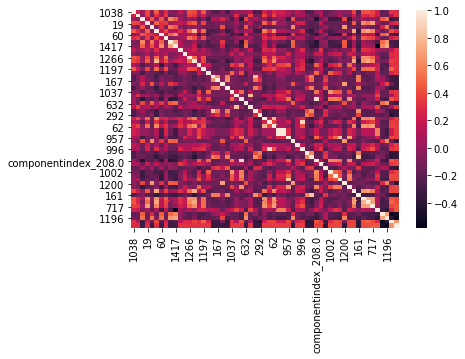

In [4]:
corrmat = data.corr()
sorted_corrs = corrmat['infection_status'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat2 = data[strong_corrs.index].corr()
sns.heatmap(corrmat2)
plt.show()

In [5]:
strong = list(strong_corrs.sort_values(ascending=False).index)

#the top feature is infection_status so we remove that 
top10 = strong[1:11]
top25 = strong[1:26]
strong = strong[1:]
len(strong)

56

In [6]:
def log_reg(df, features):
    df1 = df.copy()
    model = LogisticRegression()
    model.fit(df1[features], df1["infection_status"])
    labels = model.predict(df1[features])
    df1['labels'] = labels
    matches = df1["labels"] == df1["infection_status"]
    correct_predictions = df1[matches == True]
    false_predictions = df1[matches == False]
    accuracy = len(correct_predictions) / len(df1)
    return df1, accuracy, false_predictions

In [7]:
top10_df, top10_acc, top10_false = log_reg(data,top10)
top25_df, top25_acc, top25_false = log_reg(data,top25)
strong_df, strong_acc, strong_false = log_reg(data,strong)

print("The accuracy for top10 is: ", top10_acc)
print("The accuracy for top25 is: ", top25_acc)
print("The accuracy for all strongly correlated features is: ", strong_acc)

The accuracy for top10 is:  0.9181286549707602
The accuracy for top25 is:  0.9532163742690059
The accuracy for all strongly correlated features is:  0.9766081871345029


To be honest, this is a little surprising even though we used the same dataset to train and test. It's surprising because our initial analysis of the metabolites made it seem like there wasn't a whole lot to separate infected from non-infected. In addition, we're looking at different forms of parasite and different sections of the gut, so the fact that there is good accuracy across so many different samples is impressive. Maybe there's something consistent across those samples. A few next steps:

- let's look at which samples were incorrect in the above models;
- let's split the data into test and train and try again on unseen data, with cross validation.

In [8]:
top10_false

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
1.0,0,1,0,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,1
19.0,0,1,1,1,0,0,0,1,1,0,...,0,2,0,1,0,0,0,0,1,1
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
48.0,0,1,1,1,0,0,1,1,1,0,...,0,1,1,0,1,0,0,0,1,0
62.0,0,1,1,1,0,0,0,1,1,0,...,0,2,1,0,0,1,0,0,1,0
66.0,0,1,1,1,0,0,0,1,1,0,...,0,3,1,0,1,0,0,0,1,0
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
76.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,1,0,0,1,0,0,1
77.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1


In [9]:
top25_false

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
62.0,0,1,1,1,0,0,0,1,1,0,...,0,2,1,0,0,1,0,0,1,0
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
76.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,1,0,0,1,0,0,1
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
133.0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1


In [10]:
strong_false

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
76.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,1,0,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1


Interestingly, the model clearly has trouble with the starved samples - those samples where insects were dissected before being allowed to feed.

### Splitting into train and test datasets

In [11]:
shuffled_rows = np.random.permutation(data.index)
shuffled_data = data.loc[shuffled_rows]

split_index = round(0.8*(len(shuffled_data)))
train = shuffled_data[:split_index]
test = shuffled_data[split_index:]


In [12]:
#We can modify this to accept train and test datasets
def log_reg(train, test_df, features):
    
    train_y = train['infection_status']
    train_X = train.drop(['infection_status'], axis=1)
    
    test_y = test['infection_status']
    test_X = test.drop(['infection_status'], axis=1)

    model = LogisticRegression()
    model.fit(train_X[features], train_y)
    labels = model.predict(test_X[features])
    results_df = test_df.copy()
    results_df['labels'] = labels
    matches = results_df["labels"] == test_y
    correct_predictions = results_df[matches == True]
    false_predictions = results_df[matches == False]
    accuracy = len(correct_predictions) / len(test_X)
    return accuracy, false_predictions

In [13]:
top10_acc_test, top10_false_test = log_reg(train,test,top10)
top25_acc_test, top25_false_test = log_reg(train,test,top25)
strong_acc_test, strong_false_test = log_reg(train,test,strong)

print("The accuracy for top10 is: ", top10_acc_test)
print("The accuracy for top25 is: ", top25_acc_test)
print("The accuracy for all strongly correlated features is: ", strong_acc_test)

The accuracy for top10 is:  0.8829787234042553
The accuracy for top25 is:  0.8936170212765957
The accuracy for all strongly correlated features is:  0.9148936170212766


In [14]:
top10_false_test

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
55.0,0,1,1,1,0,0,0,1,1,0,...,0,2,1,1,0,0,0,0,1,0
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
74.0,0,0,1,1,0,0,0,1,1,0,...,1,-1,0,0,0,1,1,0,0,1
19.0,0,1,1,1,0,0,0,1,1,0,...,0,2,0,1,0,0,0,0,1,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
1.0,0,1,0,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
58.0,0,0,1,1,0,0,0,1,1,0,...,0,2,1,1,0,0,0,0,1,0


In [15]:
top25_false_test

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
3.0,0,1,1,1,0,0,0,1,1,0,...,1,0,0,0,1,0,0,0,1,1
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
4.0,0,1,1,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,1
74.0,0,0,1,1,0,0,0,1,1,0,...,1,-1,0,0,0,1,1,0,0,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
1.0,0,1,0,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
77.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1


In [16]:
strong_false_test

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
74.0,0,0,1,1,0,0,0,1,1,0,...,1,-1,0,0,0,1,1,0,0,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
154.0,0,1,1,1,0,0,0,1,1,0,...,0,2,0,1,0,0,0,1,0,1
77.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1


Out of curiosity, let's see what happens if we use all features.

In [17]:
all_features = list(data.columns)
all_features.remove('infection_status')

In [18]:
all_acc_test, all_false_test = log_reg(train,test,all_features)

print("The accuracy for all_features is:", all_acc_test)

The accuracy for all_features is: 0.9042553191489362


No real improvement over just using strongly correlated features.
Let's move on to perform cross validation.

In [19]:
def train_and_CV_log_reg(cols):
    
    features = data[cols]
    accuracies = []
    kf = KFold(n_splits = 5, shuffle=True, random_state=3)
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = data['infection_status'].iloc[train_index], data['infection_status'].iloc[test_index]
        lg = LogisticRegression()
        lg.fit(X_train, y_train)
        predictions = lg.predict(X_test)
        
        accuracy = accuracy_score(y_test, predictions)
        
        accuracies.append(accuracy)
    avg_acc = np.mean(accuracies)
    max_acc = np.max(accuracies)
    return avg_acc, max_acc

In [20]:
top10_avg_acc, top10_max_acc = train_and_CV_log_reg(top10)
top25_avg_acc, top25_max_acc = train_and_CV_log_reg(top25)
strong_avg_acc, strong_max_acc = train_and_CV_log_reg(strong)
print("Using the top 10 features returns a maximum of", top10_max_acc, "and an average accuracy of", top10_avg_acc)
print("Using the top 25 features returns a maximum of", top25_max_acc, "and an average accuracy of", top25_avg_acc)
print("Using the top correlated features returns a maximum of", strong_max_acc, "and an average accuracy of", strong_avg_acc)

Using the top 10 features returns a maximum of 0.9411764705882353 and an average accuracy of 0.8887394957983193
Using the top 25 features returns a maximum of 0.9705882352941176 and an average accuracy of 0.9357983193277309
Using the top correlated features returns a maximum of 0.9705882352941176 and an average accuracy of 0.924033613445378


It looks like 25 features is enough for the logistic regression model. For a first try, an average of 93.5% is very satisfactory.

## Feature importance
Here we can look at the importance of each of the features in defining the model.

In [21]:
train_y = train['infection_status']
train_X = train.drop(['infection_status'], axis=1)
    
test_y = test['infection_status']
test_X = test.drop(['infection_status'], axis=1)

In [22]:
lg = LogisticRegression()
lg.fit(train_X[top25], train_y)


# summarize feature importance
importance = lg.coef_[0]
imp_list = []
for feature in zip(top25, importance):
    print('Feature:', feature[0]+',', 'Score:', feature[1])
    imp_list.append(feature)

Feature: 787, Score: 0.589007502608619
Feature: 1196, Score: -1.207211871866562
Feature: 208, Score: -0.6493065830365381
Feature: 187, Score: 0.973458981663188
Feature: 717, Score: 0.31552543918877546
Feature: 993, Score: 0.3072870685718184
Feature: 81, Score: 0.4294515582248306
Feature: 161, Score: -0.4591811314686285
Feature: 959, Score: 0.6496715739185285
Feature: 952, Score: 0.1818372560039328
Feature: 1200, Score: -0.596221160534637
Feature: componentindex_51.0, Score: 0.25946815796875794
Feature: 991, Score: 0.27018967279791667
Feature: 1002, Score: 0.8994748717925003
Feature: 18, Score: -0.5280085307451735
Feature: 927, Score: 1.0070571223900733
Feature: componentindex_208.0, Score: 0.18751595850232808
Feature: 157, Score: -0.4357643983748242
Feature: 316, Score: -0.5947796395638492
Feature: 996, Score: 0.7725253370537242
Feature: 1006, Score: 1.2693559503146903
Feature: 1288, Score: -0.5470318996707355
Feature: 957, Score: 0.26072044735363387
Feature: 486, Score: 0.709890252001

We remember that our predictions are 0 (unexposed) or 1 (exposed to parasite). These values are both positive and negative numbers, with positive numbers indicating features that predict class 1 and negative numbers designated to features predicting class 0. Let's try and visualise this now.

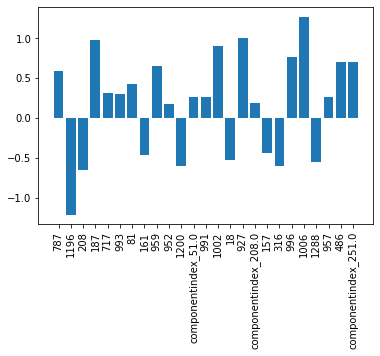

In [23]:
x_val = [x[0] for x in imp_list]
y_val = [x[1] for x in imp_list]
plt.bar(x_val,y_val)
plt.xticks(rotation=90)
plt.show()

We're going to switch to explaining our outputs with SHAP to keep it consistant across our models. 

In [24]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(lg.predict, train_X[top25])
shap_values = explainer.shap_values(train_X[top25])

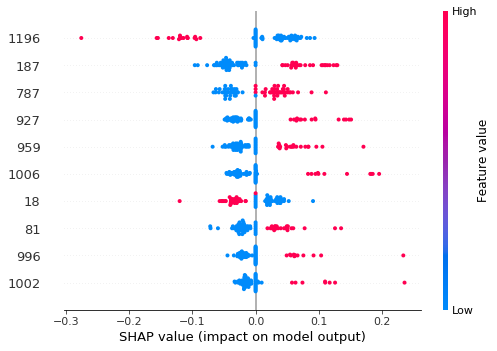

In [25]:
shap.summary_plot(shap_values, train_X[top25], max_display=10)

Here is an overview of the impact (SHAP value) of each feature for each sample. The plot is sorted by magnitude across all samples, equivalent to 'more important' in determining the final output. The color represents a feature value (red=1, blue =0). This reveals for example that the presence of metabolite 787 increases the likelihood of the insect having been exposed to infected blood.